In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# ========================= PATH =========================
INPUT_ROOT    = '/kaggle/input/csiro-biomass'
TRAIN_CSV     = f'{INPUT_ROOT}/train.csv'
TEST_CSV      = f'{INPUT_ROOT}/test.csv'
SAMPLE_SUB    = f'{INPUT_ROOT}/sample_submission.csv'
TRAIN_IMG_DIR = f'{INPUT_ROOT}/train'
TEST_IMG_DIR  = f'{INPUT_ROOT}/test'
MODEL_DIR = '/kaggle/input/resnet50-pt/pytorch/default/1/resnet50-11ad3fa6.pth'

In [3]:
# ========================= DATA =========================
train_df = pd.read_csv(TRAIN_CSV)
train_pivot = train_df.pivot_table(index='image_path', columns='target_name', values='target').reset_index()

train_set, val_set = train_test_split(train_pivot, test_size=0.2, random_state=42)

In [4]:
# ========================= TRANSFORM =========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

In [5]:
# ========================= DATASET =========================
class BiomassDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        self.targets = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, os.path.basename(row['image_path']))
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if self.is_test:
            return img, row['image_path']
        else:
            targets = row[self.targets].values.astype(np.float32)
            return img, torch.from_numpy(targets)

train_ds = BiomassDataset(train_set, TRAIN_IMG_DIR, transform)
val_ds   = BiomassDataset(val_set,   TRAIN_IMG_DIR, transform)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [6]:
# ========================= MODEL: ResNet50 v2 =========================
class BiomassModel(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet50(weights=None)
        state_dict = torch.load(MODEL_DIR)
        backbone.load_state_dict(state_dict)
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).flatten(1)
        return self.regressor(x)

model = BiomassModel().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [7]:
# ========================= TRAINING =========================
best_loss = float('inf')
print("Mulai training ...\n")
for epoch in range(25):
    model.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = torch.relu(model(xb))
            val_loss += criterion(pred, yb).item() * xb.size(0)

    train_loss /= len(train_dl.dataset)
    val_loss   /= len(val_dl.dataset)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        save_info = "← model disimpan"
    else:
        save_info = ""

    print(f"Epoch {epoch+1:2d}/25 | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} {save_info}")

Mulai training ...

Epoch  1/25 | Train Loss: 1291.1178 | Val Loss: 1022.2302 ← model disimpan
Epoch  2/25 | Train Loss: 1072.8771 | Val Loss: 745.0601 ← model disimpan
Epoch  3/25 | Train Loss: 743.3959 | Val Loss: 636.5782 ← model disimpan
Epoch  4/25 | Train Loss: 531.6907 | Val Loss: 450.8302 ← model disimpan
Epoch  5/25 | Train Loss: 380.0993 | Val Loss: 532.4816 
Epoch  6/25 | Train Loss: 318.9645 | Val Loss: 503.7036 
Epoch  7/25 | Train Loss: 280.3201 | Val Loss: 719.8561 
Epoch  8/25 | Train Loss: 229.4897 | Val Loss: 543.5966 
Epoch  9/25 | Train Loss: 219.6193 | Val Loss: 450.8896 
Epoch 10/25 | Train Loss: 179.3047 | Val Loss: 554.5064 
Epoch 11/25 | Train Loss: 169.9327 | Val Loss: 424.5916 ← model disimpan
Epoch 12/25 | Train Loss: 165.7143 | Val Loss: 619.8925 
Epoch 13/25 | Train Loss: 159.3773 | Val Loss: 535.7431 
Epoch 14/25 | Train Loss: 143.2408 | Val Loss: 329.0035 ← model disimpan
Epoch 15/25 | Train Loss: 125.3366 | Val Loss: 341.9636 
Epoch 16/25 | Train Loss: 


=== Validation Metrics (RMSE) ===
Dry_Clover_g   : 13.478
Dry_Dead_g     : 11.692
Dry_Green_g    : 16.948
Dry_Total_g    : 22.325
GDM_g          : 19.193


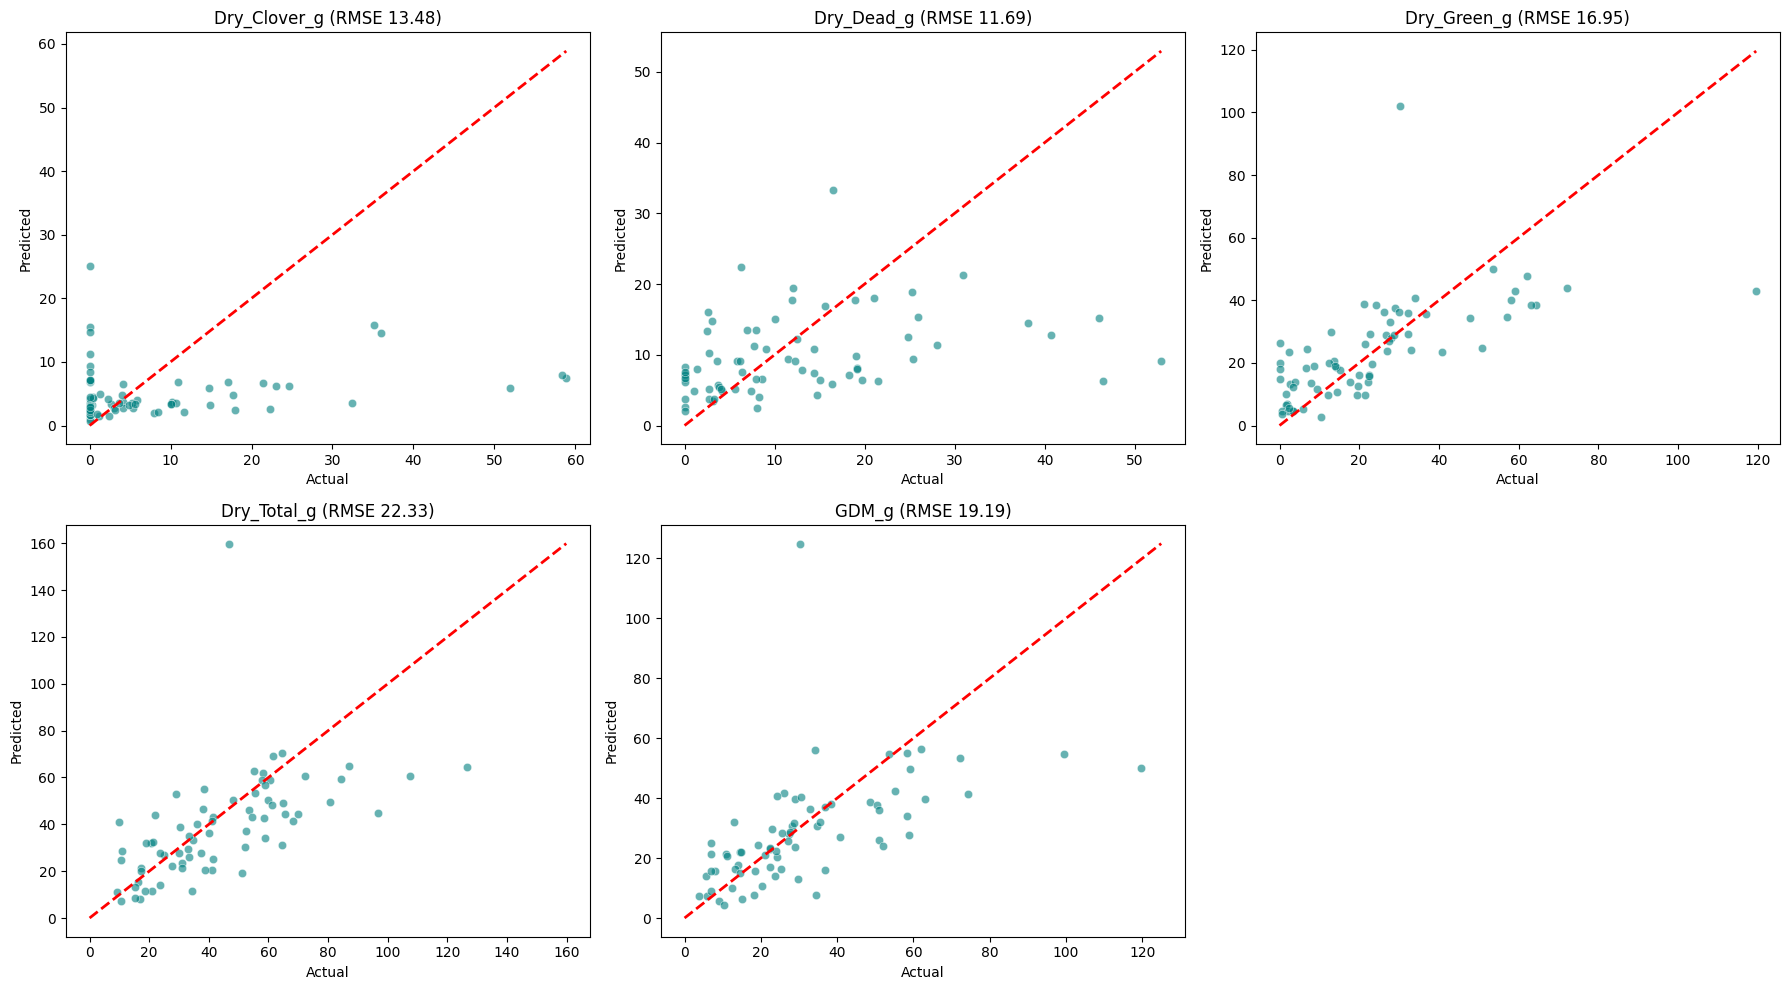

In [8]:
# ========================= EVALUATION =========================
model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
model.eval()

preds, trues = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        out = torch.relu(model(xb.to(DEVICE))).cpu().numpy()
        preds.append(out)
        trues.append(yb.numpy())

preds = np.vstack(preds)
trues = np.vstack(trues)
targets = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']

print("\n=== Validation Metrics (RMSE) ===")
for i, name in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(trues[:, i], preds[:, i]))
    print(f"{name:15s}: {rmse:6.3f}")

# Scatter plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, name in enumerate(targets):
    ax = axes[i]
    sns.scatterplot(x=trues[:, i], y=preds[:, i], ax=ax, alpha=0.6, color='teal')
    m = max(trues[:, i].max(), preds[:, i].max())
    ax.plot([0, m], [0, m], 'r--', lw=2)
    rmse = np.sqrt(mean_squared_error(trues[:, i], preds[:, i]))
    ax.set_title(f"{name} (RMSE {rmse:.2f})")
    ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [9]:
# 1. SETUP DATA UNTUK INFERENSI
test_df_long = pd.read_csv(TEST_CSV)
# Ambil daftar gambar unik (Wide Format)
unique_imgs = test_df_long[['image_path']].drop_duplicates().reset_index(drop=True)

# Dataset dan DataLoader untuk inferensi
test_ds = BiomassDataset(unique_imgs, TEST_IMG_DIR, transform, is_test=True)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

# 2. INFERENSI MODEL DAN KOLEKSI HASIL
model.eval()
image_paths = []
predictions = []

with torch.no_grad():
    for xb, paths in test_dl:
        # Melakukan prediksi dan memastikan tidak negatif (ReLU)
        out = torch.relu(model(xb.to(DEVICE))).cpu().numpy()
        
        for path, pred in zip(paths, out):
            # Menggunakan hanya nama file sebagai kunci (Kritis untuk konsistensi merge)
            image_paths.append(os.path.basename(path))
            predictions.append(pred)

# 3. WIDE TO LONG TRANSFORMATION
# Buat Wide Format DataFrame dari hasil prediksi
preds_wide = pd.DataFrame(predictions, columns=targets)
preds_wide['image_path'] = image_paths # Kunci yang sudah dibersihkan

# Ubah ke Long Format (Melting)
preds_long = preds_wide.melt(
    id_vars=['image_path'],
    value_vars=targets,
    var_name='target_name',
    value_name='target'
)

# 4. GABUNGKAN (MERGE) DAN SIMPAN
# Kunci yang digunakan di test_df_long juga harus berupa nama file saja
test_df_long['image_path_key'] = test_df_long['image_path'].apply(os.path.basename)

# Gabungkan (Merge) prediksi long format dengan sample_id
submission = pd.merge(
    test_df_long[['sample_id', 'image_path_key', 'target_name']],
    preds_long,
    left_on=['image_path_key', 'target_name'],
    right_on=['image_path', 'target_name'],
    how='left'
)

# Finalisasi kolom dan simpan
submission = submission[['sample_id', 'target']]
submission.to_csv('submission.csv', index=False)

print("\n🎉 File 'submission.csv' berhasil dibuat!")
submission.head()


🎉 File 'submission.csv' berhasil dibuat!


,sample_id,target
0,ID1001187975__Dry_Clover_g,1.119732
1,ID1001187975__Dry_Dead_g,17.070190
2,ID1001187975__Dry_Green_g,25.279892
3,ID1001187975__Dry_Total_g,43.806515
4,ID1001187975__GDM_g,25.957426
